In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle

import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps                                
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

2022-07-25 14:45:03,845 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-abyyf269', purging
2022-07-25 14:45:03,846 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-rasrr3xp', purging
2022-07-25 14:45:03,846 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-jvkzrmup', purging
2022-07-25 14:45:03,846 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-kbgxpdly', purging
2022-07-25 14:45:03,846 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-3xscj67k', purging
2022-07-25 14:45:03,846 - distributed.diskutils - INFO - Found stale lock file and directory '/jobfs/52518459.gadi-pbs/dask-worker-space/worker-1pt8n9em', purging
2022-07-25 14:45:03,84

### JRA55-do: Create monthly anomaly fields for all input variables

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-3' # 1-4-0                                                                                        #
period = ['1958','2018'] # which period to consider for anomaly calculation                                    #
version = 'v20180412' #'v20190429'                                                                             #
short = 'gn' # 'gr'                                                                                            #
# ------------------------------------------------------------------------------------------------------------ #
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
    if var[i] in ['friver', 'tos']:                     domain = 'ocean/day/';   timestep = ['0101','1231']
    print(domain+var[i]); print('--- --- --- --- ---')

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'_detrend.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    if os.path.isfile(f2) == True: # skip iteration if final .nc file already exists
        continue       

# Step I: merge files, create monthly mean fields and detrend
    cdo.detrend(input = '-monmean -mergetime ' + base + domain + var[i] + '/'+short+'/'+version+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
    # Walltime: 22min 16s for one variable

# Step II: create monthly anomalies
    field = xr.open_dataset(f1)
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month').to_netcdf(f2) # save as netcdf file

# Step II: create monthly mean and remove that to get the anomalies
#     field = xr.open_dataset(f1)
#     anom = field.groupby('time.month') - field.groupby('time.month').mean('time')
#     anom.to_netcdf(f2) # Wall time: 42.5 s for one field
#     cdo.yseassub(input = f1 +' -yseasavg -selyear,1958/1988 ' + f1, output = f2, force=False)
    
# Step II: also calculating wind stresses
rho_a = 1.25 # kg m$^{-3}$ reference air density at sea level
C_D = 1.5e-3 # unitless drag coefficient (Kara et al. 2007)
uas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[4]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').uas
vas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[5]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').vas

print('atmos/3hrPt/taux'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*uas).to_dataset(name='taux').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_taux_monthly_mean_'+period[0]+'-'+period[1]+'.nc')
print('atmos/3hrPt/tauy'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*vas).to_dataset(name='tauy').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_tauy_monthly_mean_'+period[0]+'-'+period[1]+'.nc')

# also detrend the wind stress fields and create anomalies
for s in range(2):
    if s == 0: letter = 'x'
    if s == 1: letter = 'y'
    tau1 = out+'monthly_mean/JRA55-do-'+forcing+'_tau'+letter+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    tau2 = out+'monthly_anom/JRA55-do-'+forcing+'_tau'+letter+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    cdo.detrend(input=tau1, output = tau1.replace('.nc','_detrend.nc'), force=False)
    field = xr.open_dataset(tau1.replace('.nc','_detrend.nc'))              # selecting taux or tauy variable
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[s+12]].drop('month').to_netcdf(tau2) # save as netcdf file

# Total Walltime for all 11 vars: 4h 3min 56s
# Wall time: 1min 56s when files already exist

atmos/3hrPt/huss
--- --- --- --- ---
atmos/3hrPt/psl
--- --- --- --- ---
atmos/3hrPt/tas
--- --- --- --- ---
atmos/3hrPt/ts
--- --- --- --- ---
atmos/3hrPt/uas
--- --- --- --- ---
atmos/3hrPt/vas
--- --- --- --- ---
atmos/3hr/prra
--- --- --- --- ---
atmos/3hr/prsn
--- --- --- --- ---
atmos/3hr/rlds
--- --- --- --- ---
atmos/3hr/rsds
--- --- --- --- ---
ocean/day/friver
--- --- --- --- ---
ocean/day/tos
--- --- --- --- ---
atmos/3hrPt/taux
--- --- --- --- ---
atmos/3hrPt/tauy
--- --- --- --- ---


PermissionError: [Errno 13] Permission denied: b'/g/data/e14/mv7494/JRA55-do-1-3/monthly_anom/JRA55-do-1-3_tauy_monthly_anom_1958-2018.nc'

### Calculating the N34 index and the idealised N34 polynomial

CPU times: user 26.6 s, sys: 2.15 s, total: 28.7 s
Wall time: 25.5 s


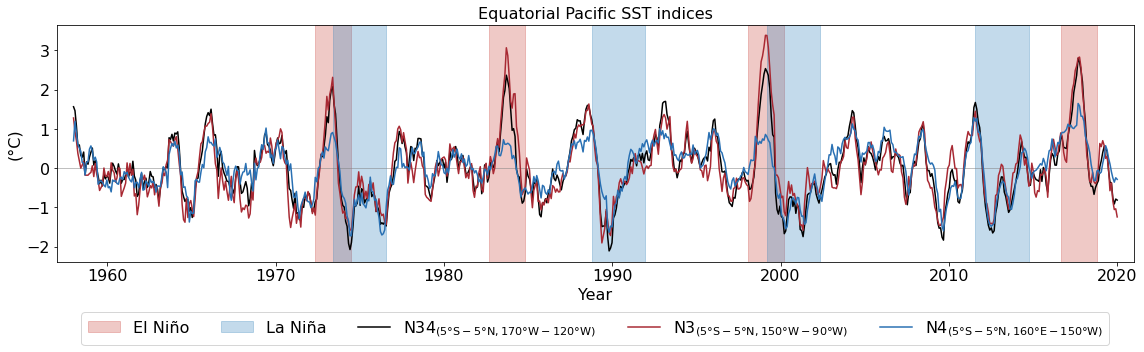

In [3]:
%%time
f11 = out+'monthly_mean/JRA55-do-'+forcing+'_'; f22 = '_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
fig = plt.figure(figsize=(16,5),tight_layout=True,facecolor='w',edgecolor='k'); gs = gridspec.GridSpec(1,1)
ax1 = plt.subplot(gs[0,0])

# remove monthly mean to calculate anomalies
ts = xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month') - (xr.open_dataset(f11 + 'ts' + f22).ts.groupby('time.month').mean('time')) 
N34_JRA = ts.isel(lat=slice(150,170)).isel(lon = slice(338,428)).mean(['lat','lon']).load() # N34 region: 5°S-5°N and 170°W-120°W -> -5.335°S ... 5.335°S, 190.1°E ... 240.2°E
N3_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(374,481)).mean(['lat','lon']).load() # N3  region: 5°S-5°N and 150°W-90°W
N4_JRA  = ts.isel(lat=slice(150,170)).isel(lon = slice(285,375)).mean(['lat','lon']).load() # N4  region: 5°S-5°N and 160°E-150°W
time = np.linspace(1958,2020,len(N34_JRA)) # I cannot use the .time attribute from the xarray array as using it does not work with ax1.axvspan()

ax1.axhline(0, linewidth=.5, c='grey')
# plot the four extreme EN event periods
ax1.axvspan(time[167], time[192], color=rotblau[4], alpha=.3); ax1.axvspan(time[287], time[312], color=rotblau[4], alpha=.3)
ax1.axvspan(time[466], time[491], color=rotblau[4], alpha=.3); ax1.axvspan(time[682], time[707], color=rotblau[4], alpha=.3, label='El Niño')
# plot the four extreme LN event periods
ax1.axvspan(time[179], time[216], color=rotblau[16], alpha=.3); ax1.axvspan(time[358], time[395], color=rotblau[16], alpha=.3)
ax1.axvspan(time[479], time[516], color=rotblau[16], alpha=.3); ax1.axvspan(time[623], time[660], color=rotblau[16], alpha=.3, label='La Niña')


plt.plot(time, N34_JRA, c='k', label='N34$_\mathrm{{ (5°S-5°N, 170°W-120°W)}}$', linewidth=1.5) # plot the data
plt.plot(time, N3_JRA, c=rotblau[3], label='N3$_\mathrm{{ (5°S-5°N, 150°W-90°W)}}$', linewidth=1.5) # plot the data
plt.plot(time, N4_JRA, c=rotblau[17], label='N4$_\mathrm{{ (5°S-5°N, 160°E-150°W)}}$', linewidth=1.5) # plot the data
plt.title('Equatorial Pacific SST indices', fontsize=16)

plt.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=5)
plt.xlim([1957,2021])
plt.ylabel('(°C)', fontsize=16); plt.xlabel('Year', fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)

# --- saving as 300 dpi .PNG image in specified folder -------------------- #
plt.savefig(save + 'JRA55-do_N34_N3_N4_timeseries', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,         #
            format=None, transparent=False, bbox_inches=None,               #
            pad_inches=0.1, metadata=None)                                  #
# --- end of script ------------------------------------------------------- #
# Wall time: 45.7 s 

### Plotting routine idealised N34 time series

CPU times: user 1.49 s, sys: 106 ms, total: 1.59 s
Wall time: 1.41 s


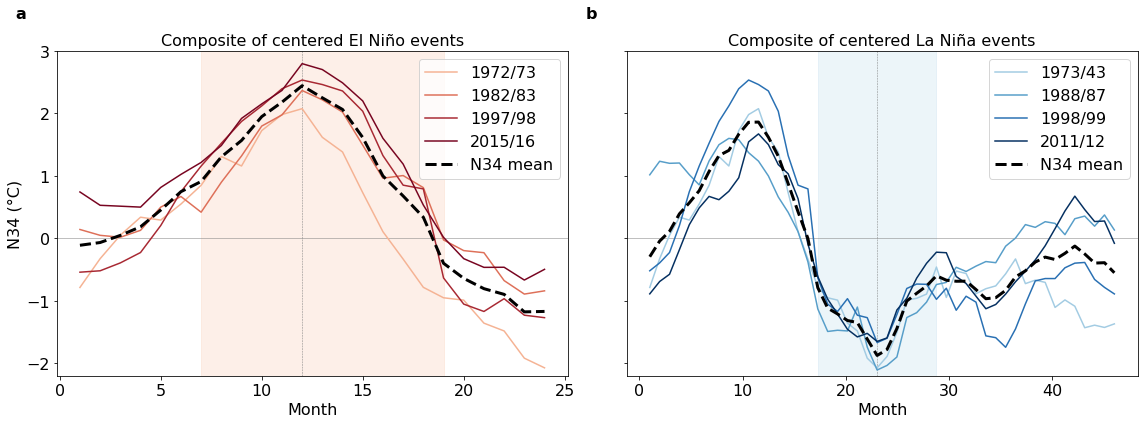

In [4]:
%%time
time = np.linspace(1,24,24) # time axis of idealised time series
time2 = np.linspace(1,24+22,24+24) # time axis of idealised time series

# top four El Niño events
EN_periods = [168,192,288,312,467,491,683,707]
N34_1972 = N34_JRA.isel(time = slice(EN_periods[0],EN_periods[1])).load() # N34 peak in 1972-12 (index 180)
N34_1982 = N34_JRA.isel(time = slice(EN_periods[2],EN_periods[3])).load() # N34 peak in 1982-12 (index 300)
N34_1997 = N34_JRA.isel(time = slice(EN_periods[4],EN_periods[5])).load() # N34 peak in 1997-11 (index 479)
N34_2015 = N34_JRA.isel(time = slice(EN_periods[6],EN_periods[7])).load() # N34 peak in 2015-12 (index 695)
# top four La Niña events
# LN_periods = [180,216,359,395,480,516,624,660]
LN_periods = [168,216,347,395,468,516,612,660]
N34_1973 = N34_JRA.isel(time = slice(LN_periods[0],LN_periods[1])).load() # N34 peak in 1972-12 (index 192)
N34_1988 = N34_JRA.isel(time = slice(LN_periods[2],LN_periods[3])).load() # N34 peak in 1984-12 (index 370)
N34_1998 = N34_JRA.isel(time = slice(LN_periods[4],LN_periods[5])).load() # N34 peak in 1997-11 (index 491)
N34_2011 = N34_JRA.isel(time = slice(LN_periods[6],LN_periods[7])).load() # N34 peak in 2015-12 (index 634)

filename= 'Composite_N34_PC2_time_series_JRA'
# ------------------------------------------------------------------- #
# initialise figure
fig = plt.figure(figsize=(16,6),tight_layout=True,facecolor='w',edgecolor='k')
event = ['El Niño', 'La Niña']
# ---------------------------- subplot 1 ---------------------------- #
for f in range(2):
    ax1 = plt.subplot(1,2,f+1)
    plt.axhline(0, c = 'grey', linewidth=.5)

    if f == 0:
        plt.axvline(12, linestyle = '--', c = 'grey', linewidth=.5)
        plt.plot(time, N34_1972, label = '1972/73', color=rotblau[7])
        plt.plot(time, N34_1982, label = '1982/83', color=rotblau[5])
        plt.plot(time, N34_1997, label = '1997/98', color=rotblau[3])
        plt.plot(time, N34_2015, label = '2015/16', color=rotblau[1])
    if f == 1:
        plt.axvline(12+11, linestyle = '--', c = 'grey', linewidth=.5)
        plt.plot(time2, N34_1973, label = '1973/43', color=rotblau[13])
        plt.plot(time2, N34_1988, label = '1988/87', color=rotblau[15])
        plt.plot(time2, N34_1998, label = '1998/99', color=rotblau[17])
        plt.plot(time2, N34_2011, label = '2011/12', color=rotblau[20])
  
    EN_mean = np.zeros(24); LN_mean = np.zeros(24+24)
    for i in range(24):
        EN_mean[i] = (N34_1972[i]+N34_1982[i]+N34_1997[i]+N34_2015[i])/4
    for i in range(24+24):
        LN_mean[i] = (N34_1973[i]+N34_1988[i]+N34_1998[i]+N34_2011[i])/4
    
    if f == 0:
        plt.plot(time, EN_mean, label = 'N34 mean', c = 'k', linestyle = '--', linewidth=3)
        poly1 = np.poly1d(np.polyfit(time, EN_mean,4))
        # N34_JRA_poly = poly1(time) # new time series constructed from the polynomial
        # plt.plot(time, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[17])
        ax1.axvspan(time[6], time[18], color=rotblau[8], alpha=.3) # shade period July to June the following year
    if f == 1:
        plt.plot(time2, LN_mean, label = 'N34 mean', c = 'k', linestyle = '--', linewidth=3)
        poly2 = np.poly1d(np.polyfit(time2, LN_mean,4))
        # N34_JRA_poly = poly2(time2) # new time series constructed from the polynomial
        # plt.plot(time2, N34_JRA_poly, linewidth=3, label = '4th order polynomial', color=rotblau[3])
        ax1.axvspan(time2[6+11], time2[18+11], color=rotblau[12], alpha=.3)

    plt.legend(fontsize=16); plt.title('Composite of centered '+event[f]+' events', fontsize=16)
    ax1.set_xlabel('Month', fontsize=16)
    if f == 0: ax1.set_ylabel('N34 (°C)', fontsize=16)
    # set fontsizes and labels
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    if f == 1: ax1.set_yticklabels([]) # overwrite x-axis tick (i.e. longitude) labels
    ax1.text(-.08, 1.1,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.ylim([-2.2,3])
# --- saving as 300 dpi .PNG image in specified folder ------------- #
plt.savefig(save + filename, dpi=300, facecolor='w',                 #
            edgecolor='w', orientation='landscape', papertype=None,  #
            format=None, transparent=False, bbox_inches=None,        #
            pad_inches=0.1, metadata=None)                           #
# --- end of script ------------------------------------------------ # # Wall time: 30.3 s

### Here the HEAVY-LIFTING: saving the anomalous forcing fields and idealised time series as .nc files
script based on the one from Ryan in 
/home/561/rmh561/access-om2/1deg_jra55v14_ryf_rcpWCWCpactest/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

and the one from Matt on github
https://github.com/mpudig/1deg_jra55_ryf/blob/v14_rcp_sinusoid_x1_period7/ACCESS-OM2_OceanHeat_Make_Scaling.ipynb

In [5]:
%%time

# first delete the files if they already exist as otherwise the script runs into problems --- #
os.system('rm -r /g/data/e14/mv7494/JRA55-do-1-3/spatial_patterns/sp_mean_anoms_*')
os.system('rm -r /g/data/e14/mv7494/JRA55-do-1-3/time_series/ts_mean_anoms_*')
# ------------------------------------------------------------------------------------------- #

# define start and end times (based on "experiment" calendar, see https://github.com/COSIMA/access-om2/wiki/Tutorials#Scaling-the-forcing-fields)
tstart = 2550 # start year of window in which scaling will be applied (1900 = initial time of control simulation)
seconds_in_year = (cftime.DatetimeNoLeap(1901,1,1,0,0,0,0) - cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()

JRAout = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/' # Output location for storing scaling files created by this script
var  = ['q_10',     'slp', 't_10',    'u_10',    'v_10',    'rain', 'snow', 'rlds', 'rsds', 'runoff_all'] # input variables for ACCESS-OM2
var2 = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for JRA55-do-1-3
var3 = ['huss',     'psl', 'tas',     'uas',     'vas',     'prra', 'prsn', 'rlds', 'rsds', 'friver']     # field variables for monthly JRA55-do-1-3 files

for n in range(2): # loop through the different simulations
    if n == 0: suffix = 'mean_anoms_EN'; periode = EN_periods; tend = 2551 # end year of window in which scaling will be applied
    if n == 1: suffix = 'mean_anoms_LN'; periode = LN_periods; tend = 2553 # end year of window in which scaling will be applied

    print('Creating time series and anomalous maps for '+suffix+':')
    print('----------------------------------------------------------')

    for i in range(len(var)): # loop through all variables except taux and tauy
        # get the JRA55-do field for the file structure
        if var[i] in ['q_10','slp','t_10','u_10','v_10']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; length_year = 2920;
        if var[i] in ['rain','snow','rlds','rsds']:       domain = 'atmos/3hr/';   timestep = ['01010130','12312230']
        if var[i] in ['runoff_all']:                      domain = 'land/day/';    timestep = ['0101','1231'];         length_year = 365;
        print(domain+var[i])
        
        JRA_field = xr.open_dataset('/g/data/ik11/inputs/JRA-55/RYF/v1-3/RYF.'+var[i]+'.1990_1991.nc') 
        # period = 7 * 365.25 / 365 # years. NB: Need to scale the period to get rid of the leap year calendar issue that was not resolved as at 31/08/21.
        num_of_leap_day_losses = np.floor((tstart - 1900)/4 - (tstart - 1900)/100 + (tstart - 1900)/400) # number of leaps days between tstart and 1900
        zeroYR = tstart - 1900 + num_of_leap_day_losses / 365  # years. determines only when the zero in the time series sinusoid, not the zero that access sees                

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Creating time series files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        # Extract time series and structure from original files:
        timeRYF = JRA_field[var2[i]].time.values
        timeFULL = np.concatenate(np.array([np.array([cftime.DatetimeNoLeap(year,x.month,x.day,x.hour,0,0,0) for x in timeRYF]) for year in np.arange(tstart,tend+1)])).ravel()
        # hmaurice: 
        from datetime import timedelta
        timeFULL = timeFULL + timedelta(days=num_of_leap_day_losses) # shift the full date time array by the number of leap days forward
        timeYR = np.array([(x-cftime.DatetimeNoLeap(1900,1,1,0,0,0,0)).total_seconds()/seconds_in_year for x in timeFULL])     

        # interpolate Nino3.4 time series to correct temporal resolution of input file
        if n == 0:      # np.interp(              target length           ,            original length              , original data)
            time_series = np.interp(np.linspace(1,24,len((timeYR-zeroYR))), np.linspace(0,len(EN_mean),len(EN_mean)), EN_mean)

# # create a step function for testing ----- #
#             time_series[0:8*31] = 0
#             time_series[8*31:8*31+8*28] = 50
#             time_series[8*31+8*28:] = 0
# # ---------------------------------------- #

        if n == 1: 
            time_series = np.interp(np.linspace(1,48,len((timeYR-zeroYR))), np.linspace(0,len(LN_mean),len(LN_mean)), LN_mean)
            
                
        # Create new Datasets:
        ds = xr.DataArray(time_series, dims=['time'], coords={'time': timeFULL}, attrs=JRA_field[var2[i]].attrs)
        DS_out = JRA_field.drop_vars(var2[i]).assign_coords({'time':timeFULL}) 
        DS_out[var2[i]] = ds
        DS_out.attrs.update({'title': 'Scaling for ' + DS_out.attrs['title']})
        DS_out.time.attrs.update(JRA_field.time.attrs) # get the right attribute from the JRA file
        DS_out.time.encoding['units'] = "days since '1900-01-01'" 
#         double time(time) ;
#                 time:_FillValue = NaN ;
#                 time:cartesian_axis = "T" ;
#                 time:modulo = " " ;
#                 time:axis = "T" ;
#                 time:units = "days since 1900-01-01" ;
#                 time:calendar = "noleap" ;

        if i == 0: ts_huss_10m = DS_out.huss_10m
        if i == 1: ts_psl      = DS_out.psl
        if i == 2: ts_tas_10m  = DS_out.tas_10m
        if i == 3: ts_uas_10m  = DS_out.uas_10m
        if i == 4: ts_vas_10m  = DS_out.vas_10m
        if i == 5: ts_prrn     = DS_out.prrn
        if i == 6: ts_prsn     = DS_out.prsn
        if i == 7: ts_rlds     = DS_out.rlds
        if i == 8: ts_rsds     = DS_out.rsds
        if i == 9: ts_friver   = DS_out.friver               

        

        # ---------------------------------------------------------------------------------------------------------------------------------- #        
        # Create spatial scaling files:
        # ---------------------------------------------------------------------------------------------------------------------------------- #
        DS_out = JRA_field.isel(time=0)
        anom = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-'+forcing+'/monthly_anom/'+'JRA55-do-'+forcing+'_'+
                               var3[i]+'_monthly_anom_1958-2018.nc')[var3[i]]

        # index['time'] = field.time # replace N34 time step values with the values from the field

        # calculate the mean anomalies during the four extreme EN periods
        # peak of event is during the 12th month of the event, therefore select 
        # anomalies 6 months prior to 6 months after and take the mean
        if n == 0: # if El Niño event
            DS_out = (anom[periode[0]+6:periode[0]+18,:,:].mean('time') + anom[periode[2]+6:periode[2]+18,:,:].mean('time') + \
                anom[periode[4]+6:periode[4]+18,:,:].mean('time') + anom[periode[6]+6:periode[6]+18,:,:].mean('time'))/4
            DS_out[var2[i]] = DS_out 
# # create a globally uniform spatial pattern ----- #
#             DS_out = DS_out.where(DS_out == 0,1)
# # ----------------------------------------------- #


        if n == 1: # if La Niña event -> a bit different as the time series is much longer
            DS_out = (anom[periode[0]+17:periode[0]+28,:,:].mean('time') + anom[periode[2]+17:periode[2]+28,:,:].mean('time') + \
                anom[periode[4]+17:periode[4]+28,:,:].mean('time') + anom[periode[6]+17:periode[6]+28,:,:].mean('time'))/4 
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CHECK THIS WITH RYAN !!!!!!!!!! #
#                                                                                                       and also multiply to get the correct sign #
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CHECK THIS WITH RYAN !!!!!!!!!! #

            DS_out[var2[i]] = DS_out 
            
        # if var[i] == 'slp': # plot as check
        #     ax1 = plt.subplot(1,2,2, projection=ccrs.SouthPolarStereo(central_longitude=0))
        #     ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
        #     p1 = DS_out.plot.contourf(ax=ax1, levels=np.linspace(-500,500,21), 
        #                                cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree()); fancy_plot(ax1)

                                 # DS_out[var2[i]] = ((anom*index).mean(['time'])) # regress N34 onto anomalies
        # Save back to netcdf:
        # DS_out.to_netcdf(JRAout+'spatial_patterns/RYF.'+var2[i]+'.1990_1991_pattern_'+suffix+'.nc') # save as netcdf file
        
        if i == 0: huss_10m = DS_out.drop(['height','huss_10m'])
        if i == 1: psl      = DS_out
        if i == 2: tas_10m  = DS_out.drop(['height','tas_10m'])
        if i == 3: uas_10m  = DS_out.drop(['height','uas_10m'])
        if i == 4: vas_10m  = DS_out.drop(['height','vas_10m'])
        if i == 5: prrn     = DS_out.drop(['prrn'])
        if i == 6: prsn     = DS_out.drop(['prsn'])
        if i == 7: rlds     = DS_out.drop(['rlds'])
        if i == 8: rsds     = DS_out.drop(['rsds'])
        if i == 9: friver   = DS_out.drop(['friver'])
    
    # saving the time series back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': ts_huss_10m, 'psl': ts_psl, 'tas_10m': ts_tas_10m,
                      'uas_10m': ts_uas_10m, 'vas_10m': ts_vas_10m,
                      'prrn': ts_prrn, 'prsn': ts_prsn,
                      'rlds': ts_rlds, 'rsds': ts_rsds})
    DS4.to_netcdf('/g/data/e14/mv7494/JRA55-do-'+forcing+'/time_series/ts_'+suffix+'.nc')

    # separate file for friver as it has a resolution of (730)
    ts_friver.to_netcdf('/g/data/e14/mv7494/JRA55-do-'+forcing+'/time_series/ts_'+suffix+'_friver.nc')  
    
    # saving the spatial patterns back into xarray structure as a .netcdf file
    # ------------------------------------------------------------------------ #
    DS4 = xr.Dataset({'huss_10m': huss_10m, 'psl': psl, 'tas_10m': tas_10m,
                      'uas_10m': uas_10m, 'vas_10m': vas_10m,
                      'prrn': prrn, 'prsn': prsn,
                      'rlds':rlds, 'rsds': rsds})  
    DS4.to_netcdf('/g/data/e14/mv7494/JRA55-do-'+forcing+'/spatial_patterns/sp_'+suffix+'.nc')
    friver.to_netcdf('/g/data/e14/mv7494/JRA55-do-'+forcing+'/spatial_patterns/sp_'+suffix+'_friver.nc')
        
    print('----------------------------------------------------------')
# Wall time: 43.3 s       per variable 
# Wall time: 16min 30s for all variables

Creating time series and anomalous maps for mean_anoms_EN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
Creating time series and anomalous maps for mean_anoms_LN:
----------------------------------------------------------
atmos/3hrPt/q_10
atmos/3hrPt/slp
atmos/3hrPt/t_10
atmos/3hrPt/u_10
atmos/3hrPt/v_10
atmos/3hr/rain
atmos/3hr/snow
atmos/3hr/rlds
atmos/3hr/rsds
land/day/runoff_all
----------------------------------------------------------
CPU times: user 4.64 s, sys: 2.59 s, total: 7.23 s
Wall time: 6.91 s


### Now for the ACCESS-OM2-01 model I need to revert back to the original anomaly design as it does not yet support the anomalous forcing in atmosphere/forcing.json

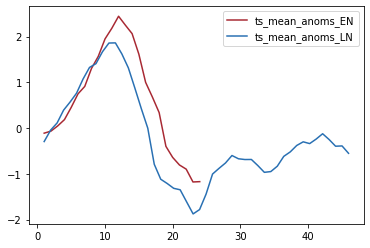

In [6]:
plt.plot(time, EN_mean, c = rotblau[3], label='ts_mean_anoms_EN')
plt.plot(time2, LN_mean, c = rotblau[17], label='ts_mean_anoms_LN'); plt.legend()

In [166]:
%%time
from scipy.interpolate import interp1d # using scipy here for the interpolation for N34 onto higher resolution
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
var = ['huss','psl','tas', 'uas','vas','prra','prsn','rlds','rsds','friver'] # only eight of the variables I used in my Msc
  
for e in range(2): # loop through the El Niño and La Niña events
    if e == 0: 
        print('Creating anomalous forcing fields for '+suffix+', 2-yr EXP:')
        suffix = 'ENFull'; save_folder = 'mean_anoms_ENFull/'
        ts = EN_mean # the original time series
    if e == 1: 
        print('Creating anomalous forcing fields for '+suffix+', 4-yr EXP:')
        suffix = 'LNFull'; save_folder = 'mean_anoms_LNFull/'
        ts = LN_mean # the original time series
    print('----------------------------------------------------------')
    
    for i in [2]:#range(len(var)): # loop through all variables
        if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['199001010000','199012312230']; length_year = 2920
        if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['199001010130','199101010000']; length_year = 2920
        if var[i] in ['friver']:                            domain = 'ocean/day/';    timestep = ['19900101','19911231'];         length_year = 365
        # load in JRA55-do field to get the correct .nc file structure
        JRA_field = xr.open_dataset(base+domain+var[i]+'/gn/v20180412/'+
                        var[i]+'_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-'+forcing+'_gn_'+timestep[0]+'-'+timestep[1]+'.nc')[var[i]]
        if var[i] != 'friver':                  
            pattern = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-5-0/N34_regressed_anom_fields.nc')[var[i]].load()
        else: 
            pattern = xr.open_dataset('/g/data/e14/mv7494/JRA55-do-1-5-0/N34_regressed_anom_fields_friver.nc')[var[i]].load()
        print(domain+var[i])

        # N34_JRA_highres = poly1(np.linspace(1,25,length_year*2)) # interpolate Nino3.4 polynomial to correct temporal resolution of input file        

        x_old = np.linspace(0,len(ts),len(ts)) # original x-axis
        x_new = np.linspace(0,len(ts),length_year*int(len(ts)/12)) # new x-axis -> if El Niño, then 2920*2, if La Niña, then 2920*4

        f_linear = scipy.interpolate.interp1d(x_old,ts) # interpolation function
        N34_JRA_highres = f_linear(np.linspace(0,len(ts),length_year*int(len(ts)/12))) # interpolated time series
  

        for f in [1,2,3,4]: # loop through the number of years
            if f == 1: 
                time_series = N34_JRA_highres[0:length_year] # 0:2920
            if f == 2: 
                time_series = N34_JRA_highres[length_year:(2*length_year)] # 2920:5840
            if f == 3 and e == 0:
                break # for the El Niño simulation, this loop is finished early, i.e., already after two years since it's a short 2-year simulation 
                      # rather than the 4-year La Niña simulation
            if f == 3 and e == 1: # if La Niña, then my time series are four years long, so I need to split the full interpolated time series into four parts
                time_series = N34_JRA_highres[(length_year*2):(3*length_year)] 
            if f == 4 and e == 1:
                time_series = N34_JRA_highres[(length_year*3):(4*length_year)]           

            # skip iteration if file already exists
            if os.path.isfile('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'RYF.'+suffix+'.'+var[i]+'.1990_1991_yr'+str(f)+'.nc') == True:
                print('File finished: RYF.'+suffix+'.'+var[i]+'.1990_1991_yr'+str(f)+'.nc')
                continue  
            
            for t in range(length_year):
                # if t % 1000 == 0: print('time step: '+str(t)) # print every 1000th iteration to see how far the loop is ahead
                JRA_field[t,:,:] = pattern.values*time_series[t]
            JRA_field.to_netcdf('/g/data/e14/mv7494/ENSOAnt_input/'+save_folder+'RYF.'+suffix+'.'+var[i]+'.1990_1991_yr'+str(f)+'.nc')
            print('File finished: RYF.'+suffix+'.'+var[i]+'.1990_1991_yr'+str(f)+'.nc')
        print('--- --- --- --- ---')
    # Wall time: 1min 5s for one year and one variable

Creating anomalous forcing fields for LNFull, 2-yr EXP:
----------------------------------------------------------
atmos/3hrPt/tas
File finished: RYF.ENFull.tas.1990_1991_yr1.nc
File finished: RYF.ENFull.tas.1990_1991_yr2.nc
--- --- --- --- ---
Creating anomalous forcing fields for ENFull, 4-yr EXP:
----------------------------------------------------------
atmos/3hrPt/tas
File finished: RYF.LNFull.tas.1990_1991_yr1.nc
File finished: RYF.LNFull.tas.1990_1991_yr2.nc
File finished: RYF.LNFull.tas.1990_1991_yr3.nc
File finished: RYF.LNFull.tas.1990_1991_yr4.nc
--- --- --- --- ---
CPU times: user 75.9 ms, sys: 13.9 ms, total: 89.8 ms
Wall time: 86.5 ms


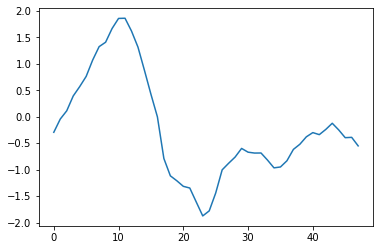

In [168]:
plt.plot(LN_mean)

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #